In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

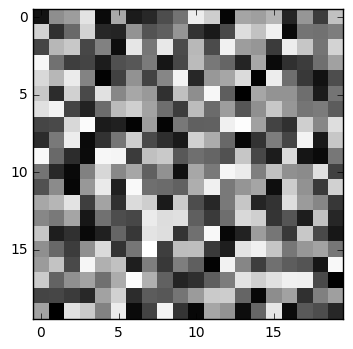

In [11]:
grid_size=[20,20]
noise = random.rand(*grid_size)
imshow(noise,interpolation='nearest',cmap='gray')

In [20]:
-inf-inf

-inf

In [12]:
infty

inf